### Download data from here: https://github.com/zalandoresearch/fashion-mnist

## Params

In [1]:
import tensorflow as tf
import numpy as np

##### Arguments ####

## Fashion MNIST Parameters
N_CLASSES = 10
IMG_WIDTH = 28
IMG_HEIGHT = 28
N_CHANNELS = 1                 # Number of Input Channels
IMAGE_LABELS = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                            'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']



## Model Parameters
CONV1_LAYER_PARAMS =  {"filters": 256,
                "kernel_size": 9,
                "activation": tf.nn.relu,
                "padding": "valid",
                "strides": 1
                }

# Parameters of PrimaryCaps_layer
MAPS_CAPS1 = 32
NCAPS_CAPS1 = MAPS_CAPS1*6*6  # Total number of primary capsules = 1152
CAPS_DIM_CAPS1 = 8            # Dimensions of each capsule

CONV2_LAYER_PARAMS  = {"filters": MAPS_CAPS1 * CAPS_DIM_CAPS1,  # Total Convolutional Filters = 256
                "kernel_size": 9,
                "strides": 2,
                "padding": "valid",
                "activation": tf.nn.relu}

# Parameters of DigitCaps_layer
NCAPS_CAPS2 = 10
CAPS_DIM_CAPS2 = 16           # Dimension of each capsule in layer 2

# Decoder Parameters
layer1_size = 512
layer2_size = 1024
output_size = IMG_WIDTH* IMG_HEIGHT

## Loss

# Margin Loss
M_PLUS = 0.9
M_MINUS= 0.1
LAMBDA = 0.5

# Reconstruction Loss
ALPHA = 0.0005

# Training Params
BATCH_SIZE = 128
EPOCHS = 5
ROUTING_ITERATIONS = 3    # Routing Iterations
STDEV = 0.01  # STDEV for Weight Initialization


## Environment and Save Directories
RESTORE_TRAINING = False            # Restores the trained model
CHECKPOINT_PATH_DIR = './datasetslib/model_dir'
LOG_DIR = './datasetslib/logs'
RESULTS_DIR = './datasetslib/results'
STEPS_TO_SAVE = 100                 # Frequency (in steps) of saving the train result

## Visualization Parameters
N_SAMPLES = 3                       # No. of Samples Images to Save

## Helper functions

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
plt.switch_backend('agg')


## Functions for Capsule Networks
def squash(vectors, name=None):
    """
    Squashing Function as implemented in the paper
    :parameter vectors: vector input that needs to be squashed
    :parameter name: Name of the tensor on the graph
    :return: a tensor with same shape as vectors but squashed as mentioned in the paper
    """
    with tf.name_scope(name, default_name="squash_op"):
        s_squared_norm = tf.reduce_sum(tf.square(vectors), axis=-2, keepdims=True)
        scale = s_squared_norm / (1. + s_squared_norm) / tf.sqrt(s_squared_norm + tf.keras.backend.epsilon())
        return scale*vectors


def routing(u):
    """
    This function performs the routing algorithm as mentioned in the paper
    :parameter u: Input tensor with [batch_size, num_caps_input_layer=1152, 1, caps_dim_input_layer=8, 1] shape.
                NCAPS_CAPS1: num capsules in the PrimaryCaps layer l
                CAPS_DIM_CAPS2: dimensions of output vectors of Primary caps layer l

    :return: "v_j" vector (tensor) in Digitcaps Layer
             Shape:[batch_size, NCAPS_CAPS1=10, CAPS_DIM_CAPS2=16, 1]
    """

    #local variable b_ij: [batch_size, num_caps_input_layer=1152, num_caps_output_layer=10, 1, 1]
                #num_caps_output_layer: number of capsules in Digicaps layer l+1
    b_ij = tf.zeros([BATCH_SIZE, NCAPS_CAPS1, NCAPS_CAPS2, 1, 1], dtype=np.float32, name="b_ij")

    # Preparing the input Tensor for total number of DigitCaps capsule for multiplication with W
    u = tf.tile(u, [1, 1, b_ij.shape[2].value, 1, 1])   # u => [batch_size, 1152, 10, 8, 1]


    # W: [num_caps_input_layer, num_caps_output_layer, len_u_i, len_v_j] as mentioned in the paper
    W = tf.get_variable('W', shape=(1, u.shape[1].value, b_ij.shape[2].value, u.shape[3].value, CAPS_DIM_CAPS2),
                        dtype=tf.float32, initializer=tf.random_normal_initializer(stddev=STDEV))
    W = tf.tile(W, [BATCH_SIZE, 1, 1, 1, 1]) # W => [batch_size, 1152, 10, 8, 16]

    #Computing u_hat (as mentioned in the paper)
    u_hat = tf.matmul(W, u, transpose_a=True)  # [batch_size, 1152, 10, 16, 1]

    # In forward, u_hat_stopped = u_hat;
    # In backward pass, no gradient pass from  u_hat_stopped to u_hat
    u_hat_stopped = tf.stop_gradient(u_hat, name='gradient_stop')

    # Routing Algorithm Begins here
    for r in range(ROUTING_ITERATIONS):
        with tf.variable_scope('iterations_' + str(r)):
            c_ij = tf.nn.softmax(b_ij, axis=2) # [batch_size, 1152, 10, 1, 1]

            # At last iteration, use `u_hat` in order to back propagate gradient
            if r == ROUTING_ITERATIONS - 1:
                s_j = tf.multiply(c_ij, u_hat) # [batch_size, 1152, 10, 16, 1]
                # then sum as per paper
                s_j = tf.reduce_sum(s_j, axis=1, keep_dims=True) # [batch_size, 1, 10, 16, 1]

                v_j = squash(s_j) # [batch_size, 1, 10, 16, 1]

            elif r < ROUTING_ITERATIONS - 1:  # No backpropagation in these iterations
                s_j = tf.multiply(c_ij, u_hat_stopped)
                s_j = tf.reduce_sum(s_j, axis=1, keepdims=True)
                v_j = squash(s_j)
                v_j = tf.tile(v_j, [1, u.shape[1].value, 1, 1, 1]) # [batch_size, 1152, 10, 16, 1]

                # Multiplying in last two dimensions: [16, 1]^T x [16, 1] yields [1, 1]
                u_hat_dot_v = tf.matmul(u_hat_stopped, v_j, transpose_a=True) # [batch_size, 1152, 10, 1, 1]

                b_ij = tf.add(b_ij,u_hat_dot_v)
    return tf.squeeze(v_j, axis=1) # [batch_size, 10, 16, 1]



def load_data(load_type='train'):
    '''

    :param load_type: train or test depending on the use case
    :return: x (images), y(labels)
    '''
    data_dir = os.path.join(os.getcwd(), 'datasetslib', 'data','fashion-mnist')
    if load_type == 'train':
        image_file = open(os.path.join(data_dir,'train-images-idx3-ubyte'))
        image_data = np.fromfile(file=image_file, dtype=np.uint8)
        x = image_data[16:].reshape((60000, 28, 28, 1)).astype(np.float32)

        label_file = open(os.path.join(data_dir, 'train-labels-idx1-ubyte'))
        label_data = np.fromfile(file=label_file, dtype=np.uint8)
        y = label_data[8:].reshape(60000).astype(np.int32)

        x_train = x[:55000] / 255.
        y_train = y[:55000]
        y_train = (np.arange(N_CLASSES) == y_train[:, None]).astype(np.float32)

        x_valid = x[55000:, ] / 255.
        y_valid = y[55000:]
        y_valid = (np.arange(N_CLASSES) == y_valid[:, None]).astype(np.float32)
        return x_train, y_train, x_valid, y_valid
    elif load_type == 'test':
        image_file = open(os.path.join(data_dir, 't10k-images-idx3-ubyte'))
        image_data = np.fromfile(file=image_file, dtype=np.uint8)
        x_test = image_data[16:].reshape((10000, 28, 28, 1)).astype(np.float)

        label_file = open(os.path.join(data_dir, 't10k-labels-idx1-ubyte'))
        label_data = np.fromfile(file=label_file, dtype=np.uint8)
        y_test = label_data[8:].reshape(10000).astype(np.int32)
        y_test = (np.arange(N_CLASSES) == y_test[:, None]).astype(np.float32)
        return x_test / 255., y_test


def shuffle_data(x, y):
    """ Shuffle the features and labels of input data"""
    perm = np.arange(y.shape[0])
    np.random.shuffle(perm)
    shuffle_x = x[perm,:,:,:]
    shuffle_y = y[perm]
    return shuffle_x, shuffle_y

def write_progress(op_type = 'train'):
    """
    Creating the handles for saving the results in a .csv file
    :return: appropriate logging files
    """
    if not os.path.exists(RESULTS_DIR):
        os.mkdir(RESULTS_DIR)
    if op_type == 'train':
        train_path = RESULTS_DIR  + '/' + 'train.csv'
        val_path = RESULTS_DIR + '/' + 'validation.csv'

        if os.path.exists(train_path):
            os.remove(train_path)
        if os.path.exists(val_path):
            os.remove(val_path)

        train_file = open(train_path, 'w')
        train_file.write('step,accuracy,loss\n')
        val_file = open(val_path, 'w')
        val_file.write('epoch,accuracy,loss\n')
        return train_file, val_file
    else:
        test_path = RESULTS_DIR + '/test.csv'
        if os.path.exists(test_path):
            os.remove(test_path)
        test_file = open(test_path, 'w')
        test_file.write('accuracy,loss\n')
        return test_file


def load_existing_details():
    """
    This function loads the train and val files to continue training
    :return: handles to train and val files and minimum validation loss
    """
    train_path = RESULTS_DIR  + '/' + 'train.csv'
    val_path = RESULTS_DIR + '/' + 'validation.csv'
    # finding the minimum validation loss so far
    f_val = open(val_path, 'r')
    lines = f_val.readlines()
    data = np.genfromtxt(lines[-1:], delimiter=',')
    min_loss = np.min(data[1:, 2])
    # loading the train and val files to continue training
    train_file = open(train_path, 'a')
    val_file = open(val_path, 'a')
    return train_file, val_file, min_loss


def eval_performance(sess, model, x, y):
    '''
    This function is mainly used to evaluate the accuracy on test and validation sets
    :param sess: session
    :param model: model to be used
    :param x: images
    :param y: labels
    :return: returns the average accuracy and loss for the dataset
    '''
    acc_all = loss_all = np.array([])
    num_batches = int(y.shape[0] / BATCH_SIZE)
    for batch_num in range(num_batches):
        start = batch_num * BATCH_SIZE
        end = start + BATCH_SIZE
        x_batch, y_batch = x[start:end], y[start:end]
        acc_batch, loss_batch, prediction_batch = sess.run([model.accuracy, model.combined_loss, model.y_predicted],
                                                     feed_dict={model.X: x_batch, model.Y: y_batch})
        acc_all = np.append(acc_all, acc_batch)
        loss_all = np.append(loss_all, loss_batch)
    return np.mean(acc_all), np.mean(loss_all)

def reconstruction(x, y, decoder_output, y_pred, n_samples):
    '''
    This function is used to reconstruct sample images for analysis
    :param x: Images
    :param y: Labels
    :param decoder_output: output from decoder
    :param y_pred: predictions from the model
    :param n_samples: num images
    :return: saves the reconstructed images
    '''

    sample_images = x.reshape(-1, IMG_WIDTH, IMG_HEIGHT)
    decoded_image = decoder_output.reshape([-1, IMG_WIDTH, IMG_WIDTH])

    fig = plt.figure(figsize=(n_samples * 2, 3))
    for i in range(n_samples):
        plt.subplot(1, n_samples, i+ 1)
        plt.imshow(sample_images[i], cmap="binary")
        plt.title("Label:" + IMAGE_LABELS[np.argmax(y[i])])
        plt.axis("off")
    fig.savefig(RESULTS_DIR + '/' + 'input_images.png')
    plt.show()

    fig = plt.figure(figsize=(n_samples * 2, 3))
    for i in range(n_samples):
        plt.subplot(1, n_samples, i + 1)
        plt.imshow(decoded_image[i], cmap="binary")
        plt.title("Prediction:" + IMAGE_LABELS[y_pred[i]])
        plt.axis("off")
    fig.savefig(RESULTS_DIR + '/' + 'decoder_images.png')
    plt.show()
    

## Build capsule networks

In [3]:
class CapsNet:
    def __init__(self):
        with tf.variable_scope('Input'):
            self.X = tf.placeholder(shape=[None, IMG_WIDTH, IMG_HEIGHT, N_CHANNELS], dtype=tf.float32, name="X")
            self.Y = tf.placeholder(shape=[None, N_CLASSES], dtype=tf.float32, name="Y")
            self.mask_with_labels = tf.placeholder_with_default(False, shape=(), name="mask_with_labels")

        self.define_network()
        self.define_loss()
        self.define_accuracy()
        self.define_optimizer()
        self.summary_()

    def define_network(self):
        with tf.variable_scope('Conv1_layer'):
            conv1_layer = tf.layers.conv2d(self.X, name="conv1_layer", **CONV1_LAYER_PARAMS) # [batch_size, 20, 20, 256]

        with tf.variable_scope('PrimaryCaps_layer'):
            conv2_layer = tf.layers.conv2d(conv1_layer, name="conv2_layer", **CONV2_LAYER_PARAMS) # [batch_size, 6, 6, 256]

            primary_caps = tf.reshape(conv2_layer, (BATCH_SIZE, NCAPS_CAPS1, CAPS_DIM_CAPS1, 1), name="primary_caps") # [batch_size, 1152, 8, 1]
            primary_caps_output = squash(primary_caps, name="caps1_output")
            # [batch_size, 1152, 8, 1]

        # DigitCaps layer, return [batch_size, 10, 16, 1]
        with tf.variable_scope('DigitCaps_layer'):
            digitcaps_input = tf.reshape(primary_caps_output, shape=(BATCH_SIZE, NCAPS_CAPS1, 1, CAPS_DIM_CAPS1, 1)) # [batch_size, 1152, 1, 8, 1]
            # [batch_size, 1152, 10, 1, 1]
            self.digitcaps_output = routing(digitcaps_input) # [batch_size, 10, 16, 1]

        # Decoder
        with tf.variable_scope('Masking'):
            self.v_norm = tf.sqrt(tf.reduce_sum(tf.square(self.digitcaps_output), axis=2, keep_dims=True) + tf.keras.backend.epsilon())

            predicted_class = tf.to_int32(tf.argmax(self.v_norm, axis=1)) #[batch_size, 10,1,1]
            self.y_predicted = tf.reshape(predicted_class, shape=(BATCH_SIZE,))  #[batch_size]
            y_predicted_one_hot = tf.one_hot(self.y_predicted, depth=NCAPS_CAPS2)  #[batch_size,10]  One hot operation

            reconstruction_targets = tf.cond(self.mask_with_labels,  # condition
                                      lambda: self.Y,  # if True (Training)
                                      lambda: y_predicted_one_hot,  # if False (Test)
                                      name="reconstruction_targets")

            digitcaps_output_masked = tf.multiply(tf.squeeze(self.digitcaps_output), tf.expand_dims(reconstruction_targets, -1)) # [batch_size, 10, 16]


            #Flattening as suggested by the paper
            decoder_input = tf.reshape(digitcaps_output_masked, [BATCH_SIZE, -1]) # [batch_size, 160]


        with tf.variable_scope('Decoder'):
            fc1 = tf.layers.dense(decoder_input, layer1_size, activation=tf.nn.relu, name="FC1") # [batch_size, 512]
            fc2 = tf.layers.dense(fc1, layer2_size, activation=tf.nn.relu, name="FC2") # [batch_size, 1024]
            self.decoder_output = tf.layers.dense(fc2, output_size, activation=tf.nn.sigmoid, name="FC3") # [batch_size, 784]


    def define_loss(self):
        # Margin Loss
        with tf.variable_scope('Margin_Loss'):
            # max(0, m_plus-||v_c||)^2
            positive_error = tf.square(tf.maximum(0., 0.9 - self.v_norm)) # [batch_size, 10, 1, 1]
            # max(0, ||v_c||-m_minus)^2
            negative_error = tf.square(tf.maximum(0., self.v_norm - 0.1)) # [batch_size, 10, 1, 1]
            # reshape: [batch_size, 10, 1, 1] => [batch_size, 10]
            positive_error = tf.reshape(positive_error, shape=(BATCH_SIZE, -1))
            negative_error = tf.reshape(negative_error, shape=(BATCH_SIZE, -1))

            Loss_vec = self.Y * positive_error + 0.5 * (1- self.Y) * negative_error # [batch_size, 10]
            self.margin_loss = tf.reduce_mean(tf.reduce_sum(Loss_vec, axis=1), name="margin_loss")

        # Reconstruction Loss
        with tf.variable_scope('Reconstruction_Loss'):
            ground_truth = tf.reshape(self.X, shape=(BATCH_SIZE, -1))
            self.reconstruction_loss = tf.reduce_mean(tf.square(self.decoder_output - ground_truth))

        # Combined Loss
        with tf.variable_scope('Combined_Loss'):
            self.combined_loss = self.margin_loss + 0.0005 * self.reconstruction_loss

    def define_accuracy(self):
        with tf.variable_scope('Accuracy'):
            correct_predictions = tf.equal(tf.to_int32(tf.argmax(self.Y, axis=1)), self.y_predicted)
            self.accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

    def define_optimizer(self):
        with tf.variable_scope('Optimizer'):
            optimizer = tf.train.AdamOptimizer()
            self.train_optimizer = optimizer.minimize(self.combined_loss, name="training_optimizer")

    def summary_(self):
        reconstructed_image = tf.reshape(self.decoder_output, shape=(BATCH_SIZE, IMG_WIDTH, IMG_HEIGHT, N_CHANNELS))
        summary_list = [tf.summary.scalar('Loss/margin_loss', self.margin_loss),
                        tf.summary.scalar('Loss/reconstruction_loss', self.reconstruction_loss),
                        tf.summary.image('original', self.X),
                        tf.summary.image('reconstructed', reconstructed_image)]
        self.summary_ = tf.summary.merge(summary_list)


## Train & Test

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use keras.layers.dense instead.
Step1: Train
Data set Loaded
All variables initialized
Training Starts
  Batch #0, Epoch: #1, Mean Training loss: 0.5638, Mean Training accuracy: 8.6%
  Batch #100, Epoch: #1, Mean Training loss: 0.8095, Mean Training accuracy: 9.8%
  Batch #200, Epoch: #1, Mean Training loss: 0.8095, Mean Training accuracy: 9.8%
  Batch #300, Epoch: #1, Mean Training loss: 0.8095, Mean Training accuracy: 10.0%
  Batch #400, Epoch: #1, Mean Training loss: 0.8095, Mean Training accuracy: 10.3%
Epoch: 1  Mean Train Accuracy: 10.3203% ,Mean Val accuracy: 10.5369%  Loss: 1.244087 (improved)
  Batch #0, Epoch: #2, Mean Training loss: 0.8086, Mean Training accuracy: 9.9%
  Batch #100, Epoch: #2, Mean T

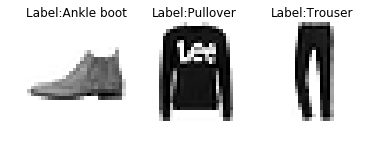

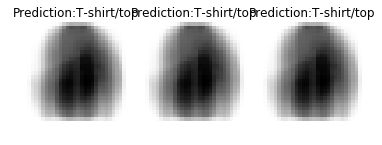

In [4]:
import os


def train(model):
    global fd_train
    x_train, y_train, x_valid, y_valid = load_data(load_type='train')
    print('Data set Loaded')
    num_batches = int(y_train.shape[0] / BATCH_SIZE)
    if not os.path.exists(CHECKPOINT_PATH_DIR):
        os.makedirs(CHECKPOINT_PATH_DIR)

    with tf.Session() as sess:
        if RESTORE_TRAINING:
            saver = tf.train.Saver()
            ckpt = tf.train.get_checkpoint_state(CHECKPOINT_PATH_DIR)
            saver.restore(sess, ckpt.model_checkpoint_path)
            print('Model Loaded')
            start_epoch = int(str(ckpt.model_checkpoint_path).split('-')[-1])
            train_file, val_file, best_loss_val = load_existing_details()
        else:
            saver = tf.train.Saver(tf.global_variables())
            tf.global_variables_initializer().run()
            print('All variables initialized')
            train_file, val_file = write_progress('train')
            start_epoch = 0
            best_loss_val = np.infty
        print('Training Starts')
        acc_batch_all = loss_batch_all = np.array([])
        train_writer = tf.summary.FileWriter(LOG_DIR, sess.graph)
        for epoch in range(start_epoch, EPOCHS):
            # Shuffle the input data
            x_train, y_train = shuffle_data(x_train, y_train)
            for step in range(num_batches):
                start = step * BATCH_SIZE
                end = (step + 1) * BATCH_SIZE
                global_step = epoch * num_batches + step
                x_batch, y_batch = x_train[start:end], y_train[start:end]
                feed_dict_batch = {model.X: x_batch, model.Y: y_batch, model.mask_with_labels: True}
                if not (step % 100):
                    _, acc_batch, loss_batch, summary_ = sess.run([model.train_optimizer, model.accuracy,
                                                                     model.combined_loss, model.summary_],
                                                                    feed_dict=feed_dict_batch)
                    train_writer.add_summary(summary_, global_step)
                    acc_batch_all = np.append(acc_batch_all, acc_batch)
                    loss_batch_all = np.append(loss_batch_all, loss_batch)
                    mean_acc,mean_loss = np.mean(acc_batch_all),np.mean(loss_batch_all)
                    summary_ = tf.Summary(value=[tf.Summary.Value(tag='Accuracy', simple_value=mean_acc)])
                    train_writer.add_summary(summary_, global_step)
                    summary_ = tf.Summary(value=[tf.Summary.Value(tag='Loss/combined_loss', simple_value=mean_loss)])
                    train_writer.add_summary(summary_, global_step)

                    train_file.write(str(global_step) + ',' + str(mean_acc) + ',' + str(mean_loss) + "\n")
                    train_file.flush()
                    print("  Batch #{0}, Epoch: #{1}, Mean Training loss: {2:.4f}, Mean Training accuracy: {3:.01%}".format(
                        step, (epoch+1), mean_loss, mean_acc))
                    acc_batch_all = loss_batch_all = np.array([])
                else:
                    _, acc_batch, loss_batch = sess.run([model.train_optimizer, model.accuracy, model.combined_loss],
                                                        feed_dict=feed_dict_batch)
                    acc_batch_all = np.append(acc_batch_all, acc_batch)
                    loss_batch_all = np.append(loss_batch_all, loss_batch)

            # Validation metrics after each EPOCH
            acc_val, loss_val = eval_performance(sess, model, x_valid, y_valid)
            val_file.write(str(epoch + 1) + ',' + str(acc_val) + ',' + str(loss_val) + '\n')
            val_file.flush()
            print("\rEpoch: {}  Mean Train Accuracy: {:.4f}% ,Mean Val accuracy: {:.4f}%  Loss: {:.6f}{}".format(
                epoch + 1, mean_acc * 100, acc_val * 100, loss_val,
                " (improved)" if loss_val < best_loss_val else ""))

            # Saving the improved model
            if loss_val < best_loss_val:
                saver.save(sess, CHECKPOINT_PATH_DIR + '/model.tfmodel', global_step=epoch + 1)
                best_loss_val = loss_val
        train_file.close()
        val_file.close()


def test(model):
    x_test, y_test = load_data(load_type='test')
    print('Loaded the test dataset')
    test_file = write_progress('test')
    saver = tf.train.Saver()
    ckpt = tf.train.get_checkpoint_state(CHECKPOINT_PATH_DIR)
    with tf.Session() as sess:
        saver.restore(sess, ckpt.model_checkpoint_path)
        print('Model Loaded')
        acc_test, loss_test = eval_performance(sess, model, x_test, y_test)
        test_file.write(str(acc_test) + ',' + str(loss_test) + '\n')
        test_file.flush()
        print('-----------------------------------------------------------------------------')
        print("Test Set Loss: {0:.4f}, Test Set Accuracy: {1:.01%}".format(loss_test, acc_test))


def reconstruct_sample(model, n_samples=5):
    x_test, y_test = load_data(load_type='test')
    sample_images, sample_labels = x_test[:BATCH_SIZE], y_test[:BATCH_SIZE]
    saver = tf.train.Saver()
    ckpt = tf.train.get_checkpoint_state(CHECKPOINT_PATH_DIR)
    with tf.Session() as sess:
        saver.restore(sess, ckpt.model_checkpoint_path)
        feed_dict_samples = {model.X: sample_images, model.Y: sample_labels}
        decoder_out, y_predicted = sess.run([model.decoder_output, model.y_predicted],
                                       feed_dict=feed_dict_samples)
    reconstruction(sample_images, sample_labels, decoder_out, y_predicted, n_samples)


def main():
    # Train the model and evaluate on test set
    model = CapsNet()
    print ("Step1: Train")
    train(model)
    print("Step2: Testing the performance of model on the Test Set")
    test(model)
    print ("Step3: Reconstructing some sample images")
    reconstruct_sample(model,n_samples =3)

if __name__ == "__main__":
    main()
